In [1]:
import sys

sys.path.insert(0,'./')
from importlib import reload

In [2]:
from lensing_lensing import *
from fisher import *

In [3]:
def fisher_calc(params=['As'],Nx=3,dx_max=0.01,do_log=False,kappa_class=None):
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    
    cl0G=kappa_class.kappa_cl_tomo()
    cl_t=cl0G['stack'].compute()
    cov=cl_t['cov']
    kappa_class.Ang_PS.reset()
    kappa_class.do_cov=False

    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    ndim=len(params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    for p in params:
        x0=cosmo_fid[p]
        if do_log:
            x0=np.absolute(x0)
            x_vars[p]=x0**Dx
            if x0==1:
                x_vars[p]=(2.**Dx)/2. # 1**x=1
            x_vars[p]*=np.sign(cosmo_fid[p])
        else:
            x_vars[p]=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
        
        models[p]={}
#         covs[p]={}
        model_derivs[p]={}
        for i in np.arange(Nx):
            cosmo_t=cosmo_fid.copy()
            cosmo_t[p]=x_vars[p][i]
            cl0G=kappa_class.kappa_cl_tomo(cosmo_params=cosmo_t)
            cl_t=cl0G['stack'].compute()
            models[p][i]=cl_t['cl']
#             covs[p][i]=cl_t['cov']
            kappa_class.Ang_PS.reset()
        model_derivs[p]=models[p][Nx-1]-models[p][0]
        if do_log:
            model_derivs[p]/=np.log(x_vars[p][Nx-1]/x_vars[p][0])
        else:
            model_derivs[p]/=(x_vars[p][Nx-1]-x_vars[p][0])
#     cov=covs[p][1]
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params:
        i2=0
        for p2 in params:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            i2+=1
        i1+=1
    print (cov_p_inv)
    out={}
    out['cov_p']=np.linalg.inv(cov_p_inv)
    out['error']=np.sqrt(np.diag(out['cov_p']))
    return out

In [100]:
lmax_cl=2000
lmin_cl=2
l_step=3 #choose odd number
l=np.arange(lmin_cl,lmax_cl,step=l_step)
l0=np.arange(lmin_cl,lmax_cl)
#l_bins=np.int64(np.linspace(lmin_cl,lmax_cl,20))#
lmin_clB=lmin_cl+10
lmax_clB=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_clB),np.log10(lmax_clB),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])
if l_step!=1:
    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20)))

do_cov=True
bin_cl=True

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)
stack_data=False

In [101]:
zs_bin1=source_tomo_bins(zp=[1],p_zp=np.array([1]),ns=26)

[0 1] [1] [ 0.9999  1.0001]


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


In [102]:
import lensing_lensing
reload(lensing_lensing)
from lensing_lensing import *

In [103]:
l.shape

(444,)

In [104]:
kappa0=Kappa(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0,
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,)#f_sky=0.35,sigma_gamma=0.37)
kappa1=Kappa(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l,#np.int32((l[1:]+l[:-1])*0.5),
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,)#f_sky=0.35)

# l are different in kappa0 and kappa1. To test if we can get aways with computation at fewer l, when binning
# with l_bins. Remeber, cl and cov are computed at some l first and then binned.

CPU times: user 6.9 ms, sys: 4.67 ms, total: 11.6 ms
Wall time: 10.8 ms
CPU times: user 6.34 ms, sys: 2.23 ms, total: 8.57 ms
Wall time: 7.6 ms


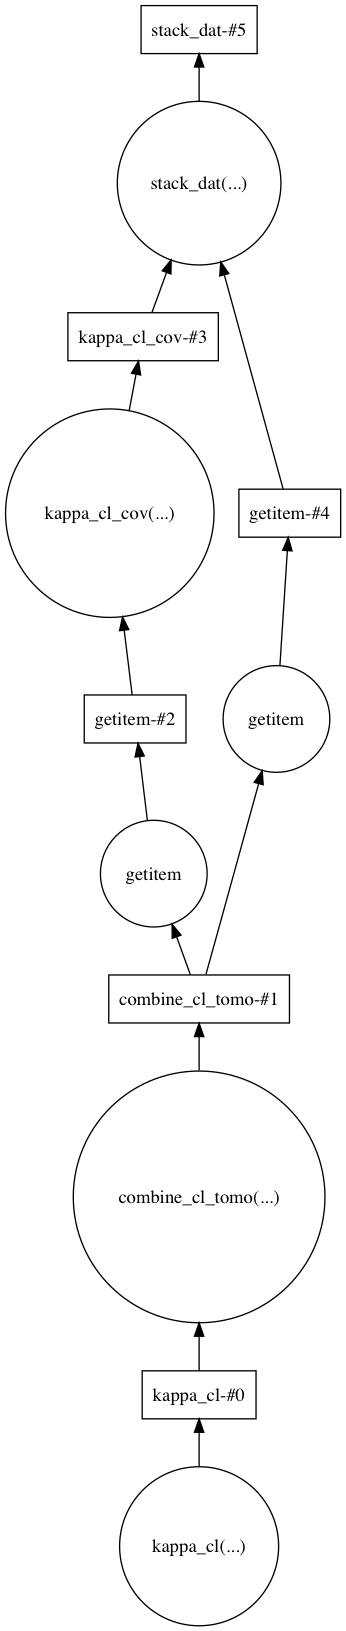

In [105]:
%time cl0G=kappa0.kappa_cl_tomo()
%time cl1G=kappa1.kappa_cl_tomo()#kappa1.kappa_cl_tomo()
cl0G['stack'].visualize()

In [106]:
%time cl0=cl0G['stack'].compute()
cov_inv=np.linalg.inv(cl0['cov'])

SN=np.sqrt(np.dot(cl0['cl'],np.dot(cov_inv,cl0['cl'])))
SN

CPU times: user 13.2 s, sys: 280 ms, total: 13.5 s
Wall time: 13.5 s


204.38018628074204

In [107]:
cl0={}
cl1={}
%time cl0['cl']=cl0G['cl0'].compute()
%time cl0['cov']=kappa0.compute_cov_tomo(cl0G['cov0'])
%time cl1['cl']=cl1G['cl0'].compute()
%time cl1['cov']=kappa1.compute_cov_tomo(cl1G['cov0'])

CPU times: user 4 ms, sys: 2.95 ms, total: 6.95 ms
Wall time: 3.87 ms
CPU times: user 435 ms, sys: 243 ms, total: 678 ms
Wall time: 306 ms
CPU times: user 13.2 s, sys: 208 ms, total: 13.4 s
Wall time: 14.1 s
CPU times: user 57.1 ms, sys: 18 ms, total: 75.1 ms
Wall time: 20.6 ms


In [108]:
cc=kappa0.cov_utils

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


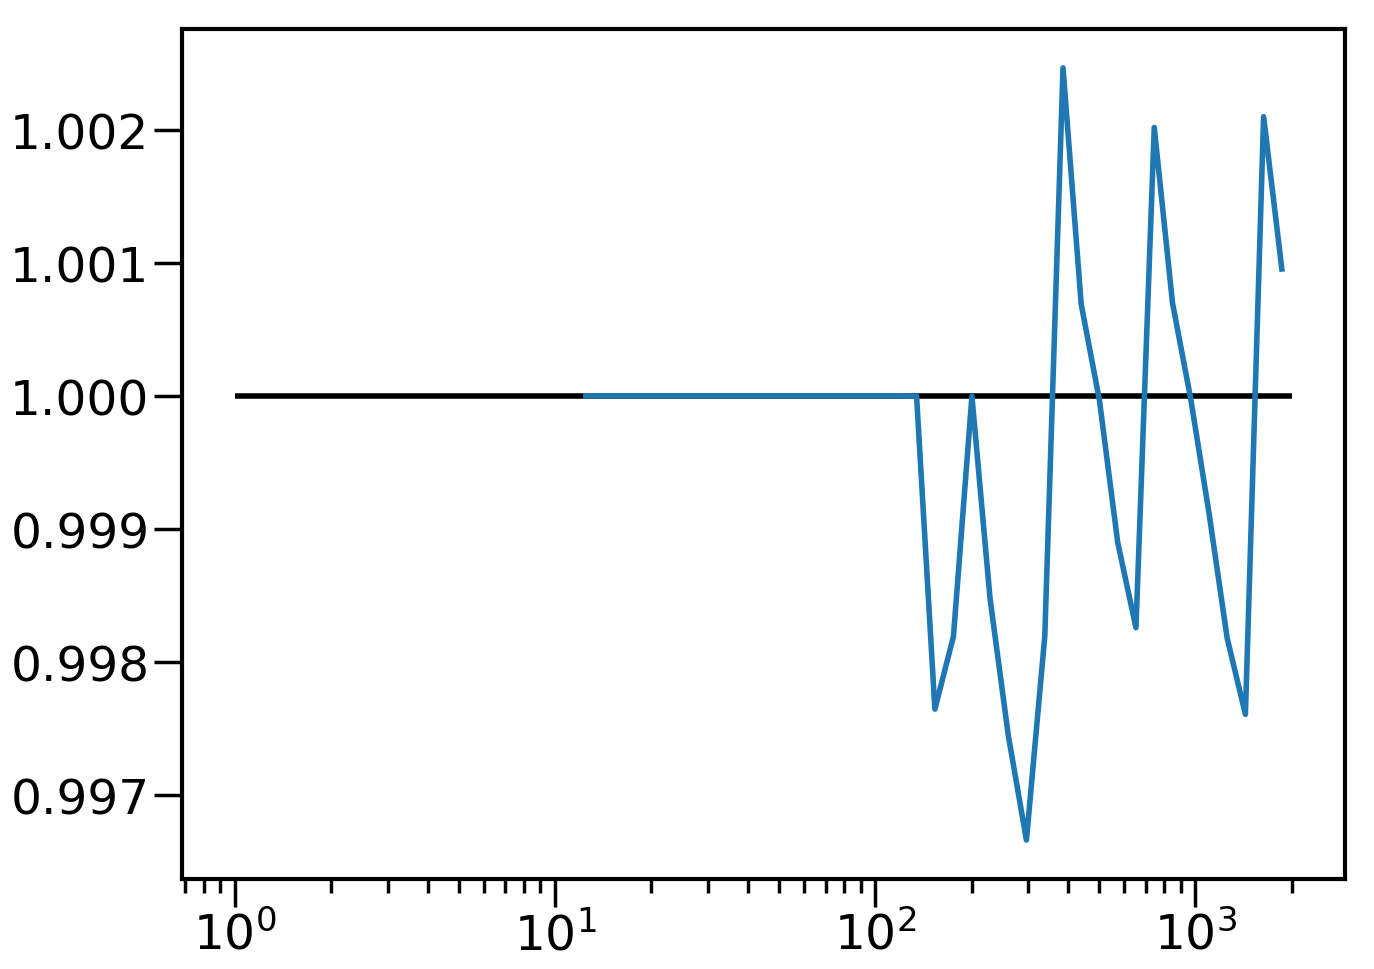

In [109]:
cl_t=cl0['cl'][:,0,0]
cl_t2=cl1['cl'][:,0,0]
plot(lb,cl_t/cl_t2)
hlines(1,1,2000)
xscale('log')
# ylim(8e-7,8.6e-7)
# yscale('log')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


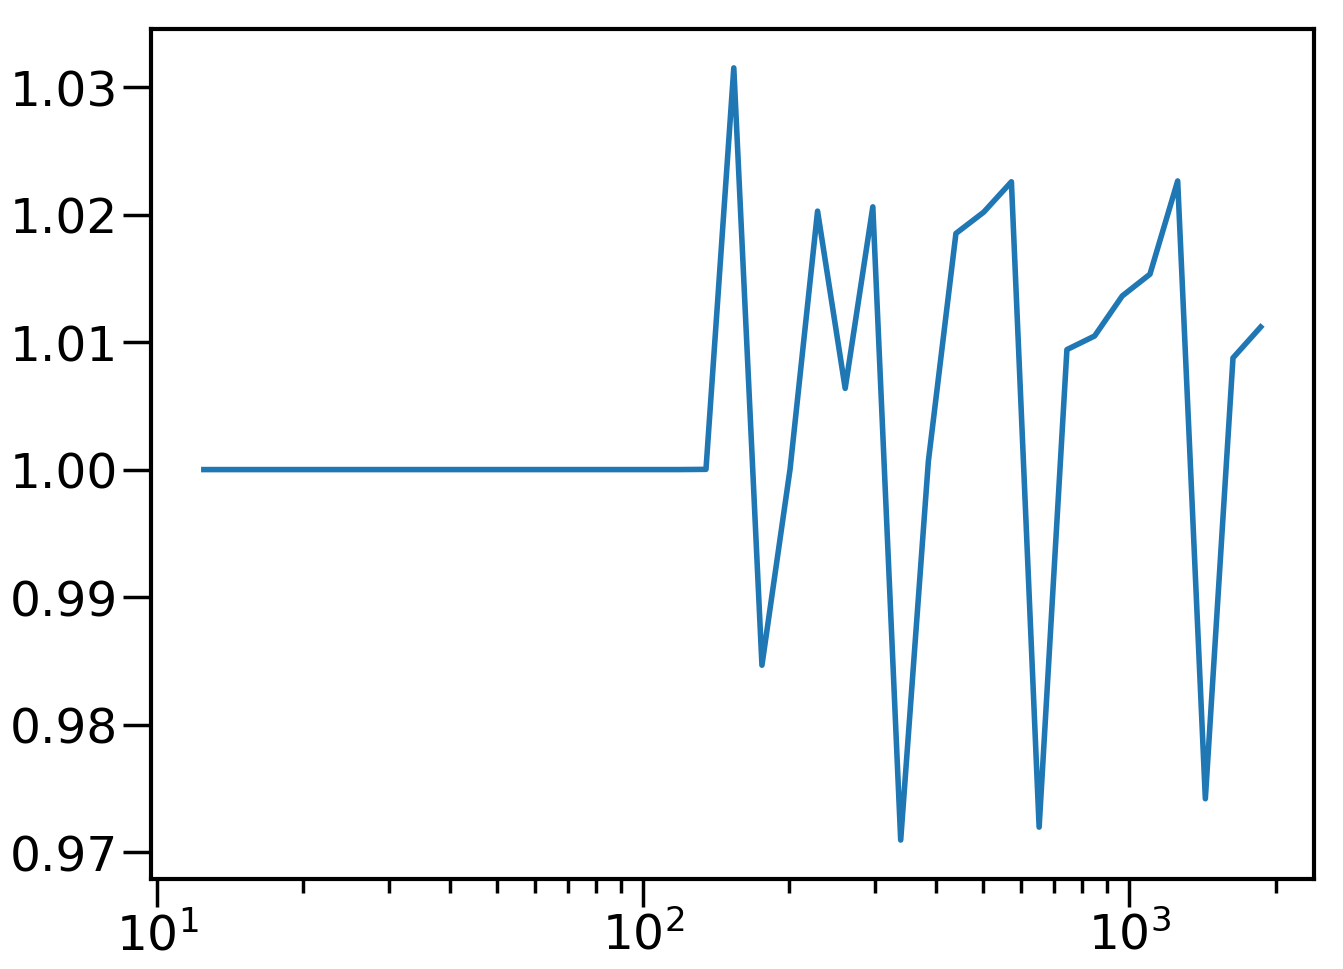

In [110]:
cov0=cl0['cov'][(0,0,0,0)]
cov02=cl1['cov'][(0,0,0,0)]
plot(lb,np.diag(cov02['G'])/np.diag(cov0['G']))
# plot(l,np.gradient(l))
xscale('log')
# yscale('log')
#ylim(0.99,1.01)

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


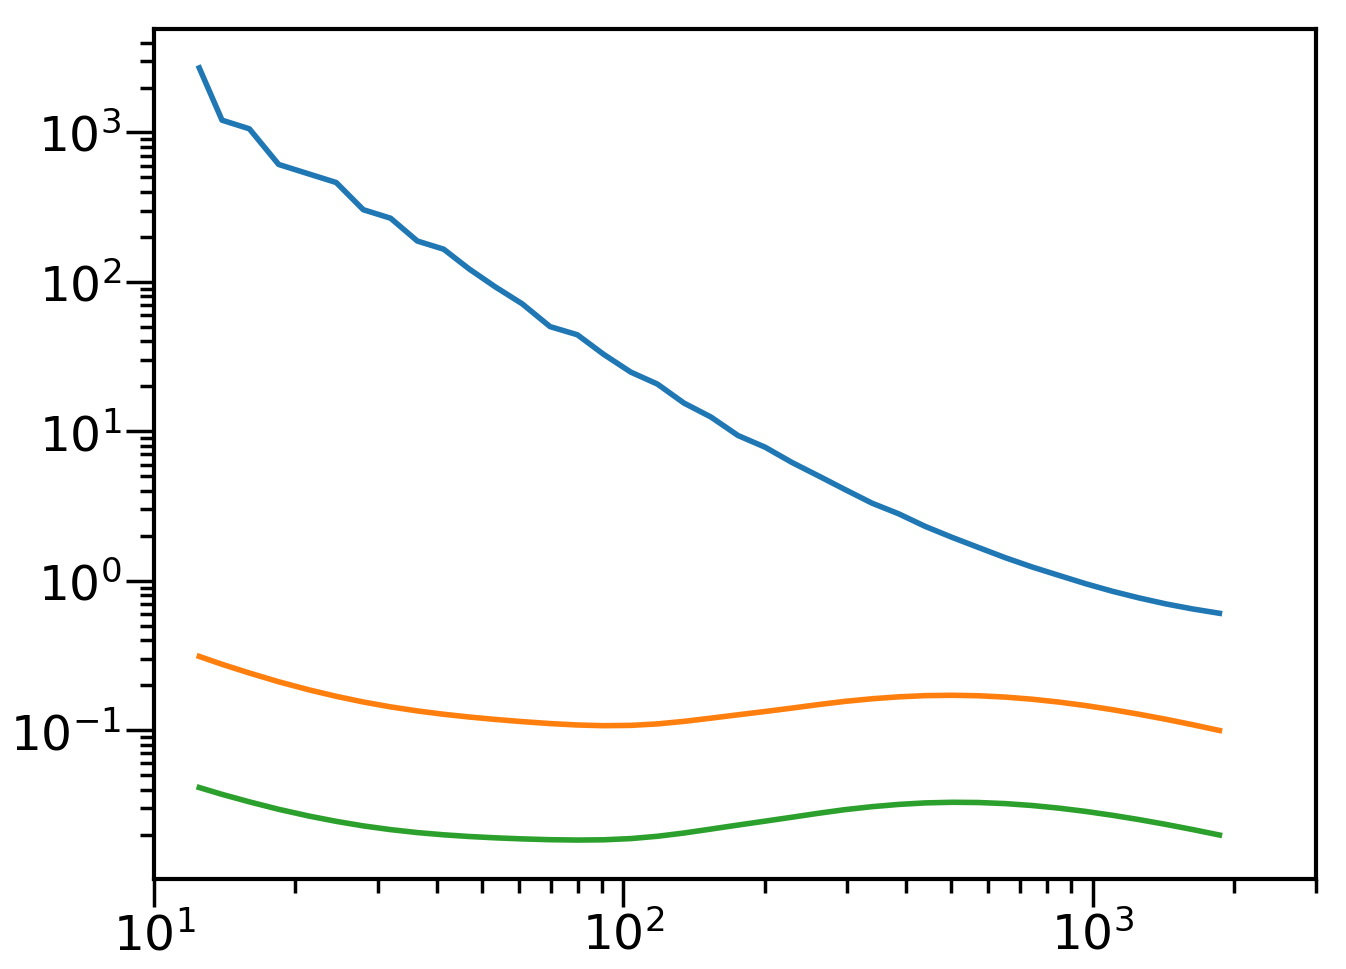

In [111]:
cov0=cl0['cov'][(0,0,0,0)]
f=1.e4
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
#plot(lb,np.diag(cov02['G'])/cl_t**2*f*0.95)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dk'])/cl_t**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

(12, 1990)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


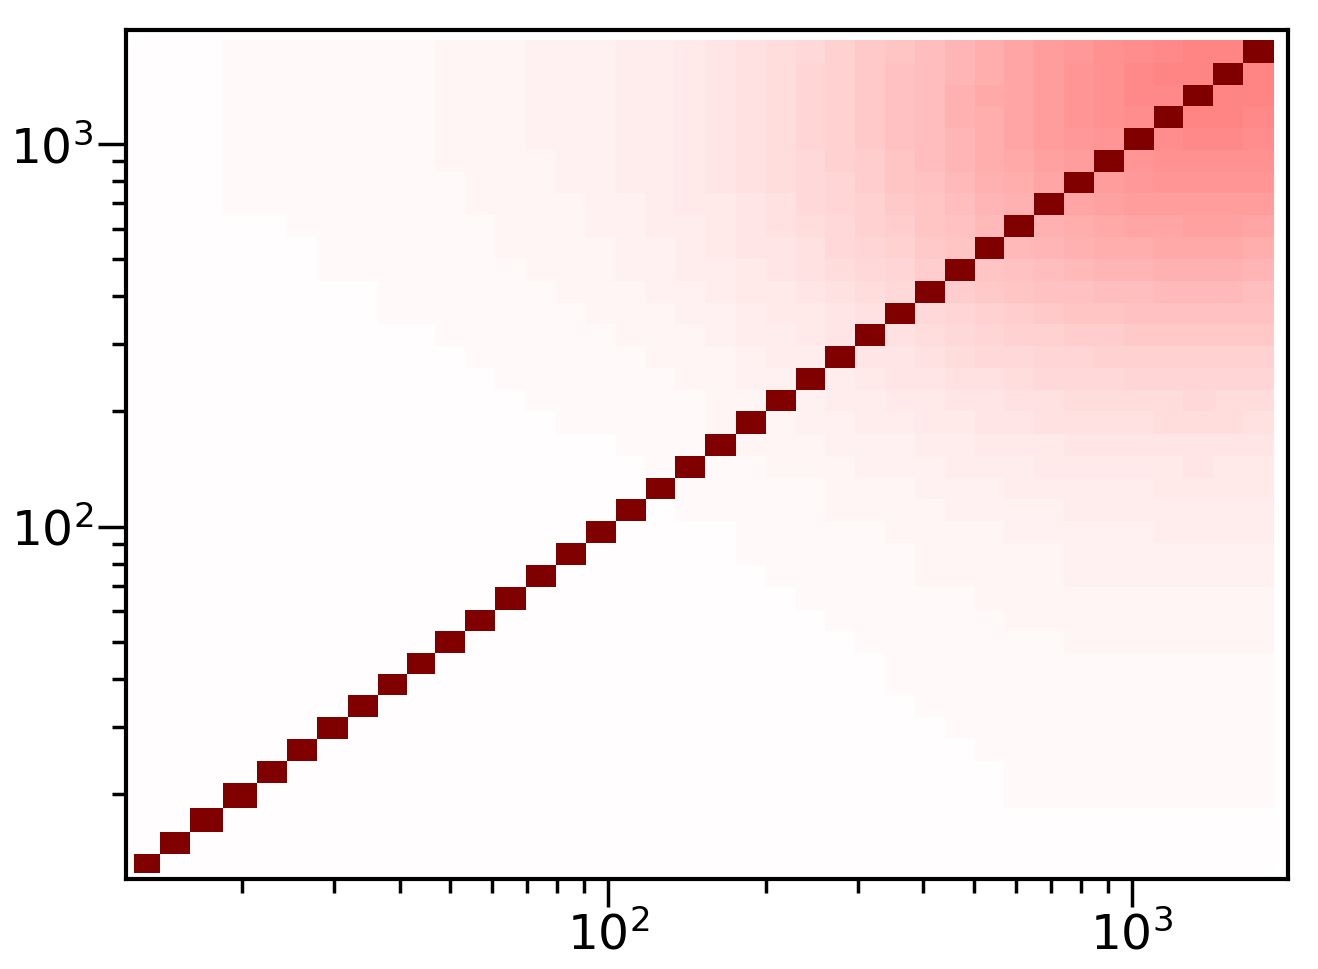

In [112]:
cov0=cl0['cov'][(0,0,0,0)]
corr2=kappa0.cov_utils.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(lmin_clB,lmax_clB)
ylim(lmin_clB,lmax_clB)

In [18]:
import lensing_utils
reload(lensing_utils)

import lsst_utils
reload(lsst_utils)
from lsst_utils import *

import lensing_lensing
reload(lensing_lensing)

from lensing_lensing import *



In [19]:
do_xi=False
bin_xi=True
bin_cl=True
th_bins=np.logspace(-1,1,20)

In [20]:
zmin=0.3
zmax=2
z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26#+np.inf
nbins=10
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=0.05*np.ones_like(z))

nbins=np.int(nbins*(nbins+1.)/2.)
zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
                          ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=0.05*np.ones_like(z))

SSV_cov=True
tidal_SSV=True

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
./lensing_utils.py:36: RuntimeWarning: invalid value encountered in multiply
  ddls=1.-np.multiply.outer(1./ds,dl)#(ds-dl)/ds
./lensing_utils.py:39: RuntimeWarning: invalid value encountered in less_equal
  x=ddls<=0 #zs<zl


[ 0 68] [ 0.30150754  0.32663317  0.35175879  0.37688442  0.40201005  0.42713568
  0.45226131  0.47738693  0.50251256  0.52763819  0.55276382  0.57788945
  0.60301508  0.6281407   0.65326633  0.67839196  0.70351759  0.72864322
  0.75376884  0.77889447  0.8040201   0.82914573  0.85427136  0.87939698
  0.90452261  0.92964824  0.95477387  0.9798995   1.00502513  1.03015075
  1.05527638  1.08040201  1.10552764  1.13065327  1.15577889  1.18090452
  1.20603015  1.23115578  1.25628141  1.28140704  1.30653266  1.33165829
  1.35678392  1.38190955  1.40703518  1.4321608   1.45728643  1.48241206
  1.50753769  1.53266332  1.55778894  1.58291457  1.6080402   1.63316583
  1.65829146  1.68341709  1.70854271  1.73366834  1.75879397  1.7839196
  1.80904523  1.83417085  1.85929648  1.88442211  1.90954774  1.93467337
  1.95979899  1.98492462] [ 0.30140754  1.98502462]


In [21]:
kappaS = Kappa(zs_bins=zs_bins,l=l,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
               stack_data=stack_data,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

kappaL = Kappa(zs_bins=zl_bins,l=l,cross_PS=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
               stack_data=stack_data,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [22]:
np.diag(kappaL.SN[0]),np.diag(kappaS.SN[0])

(array([  4.80508247e-10,   4.72204725e-10,   4.66768497e-10,
          4.63676245e-10,   4.62606207e-10,   4.63285178e-10,
          4.65507034e-10,   4.69161693e-10,   4.74100754e-10,
          4.79155960e-10,   4.85353558e-10,   4.92782253e-10,
          5.01395668e-10,   5.11166573e-10,   5.22070993e-10,
          5.34109370e-10,   5.47297126e-10,   5.61357222e-10,
          5.75639550e-10,   5.91178637e-10,   6.07995555e-10,
          6.26129904e-10,   6.45626474e-10,   6.66533533e-10,
          6.88921315e-10,   7.12864778e-10,   7.37615380e-10,
          7.63435676e-10,   7.91057950e-10,   8.20583351e-10,
          8.52129255e-10,   8.85820811e-10,   9.21793620e-10,
          9.60216188e-10,   1.00126493e-09,   1.04328828e-09,
          1.08805590e-09,   1.13597472e-09,   1.18729709e-09,
          1.24230798e-09,   1.30132218e-09,   1.36469219e-09,
          1.43283158e-09,   1.50538213e-09,   1.58103990e-09,
          1.66267355e-09,   1.75088471e-09,   1.84638182e-09,
        

In [23]:
kappaL.SN

array([[[  4.80508247e-10,   4.72254944e-10,   4.59827186e-10, ...,
           1.16583178e-10,   1.15088454e-10,   1.13647174e-10],
        [  4.72254944e-10,   4.72204725e-10,   4.66022538e-10, ...,
           1.27481607e-10,   1.25866514e-10,   1.24308638e-10],
        [  4.59827186e-10,   4.66022538e-10,   4.66768497e-10, ...,
           1.39037106e-10,   1.37297450e-10,   1.35618819e-10],
        ..., 
        [  1.16583178e-10,   1.27481607e-10,   1.39037106e-10, ...,
           2.46293594e-09,   2.53353451e-09,   2.59881216e-09],
        [  1.15088454e-10,   1.25866514e-10,   1.37297450e-10, ...,
           2.53353451e-09,   2.61729176e-09,   2.69514080e-09],
        [  1.13647174e-10,   1.24308638e-10,   1.35618819e-10, ...,
           2.59881216e-09,   2.69514080e-09,   2.78721690e-09]]])

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


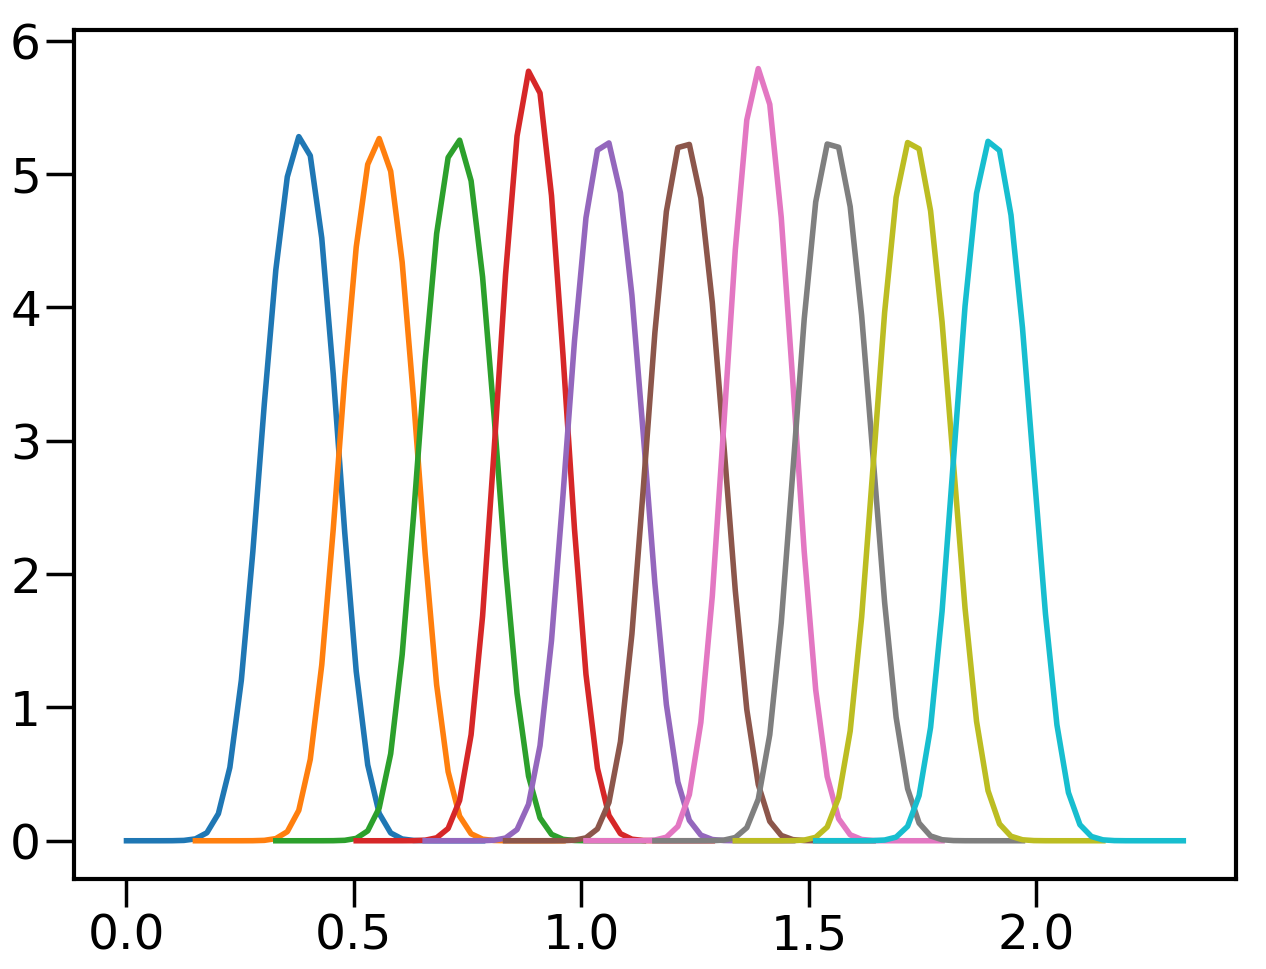

In [24]:
nb=kappaS.zs_bins['n_bins']
for i in np.arange(nb):
    zb=zs_bins[i] #kappaS.zs_bins[i]
    plot(zb['z'],zb['pz'])
# yscale('log')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


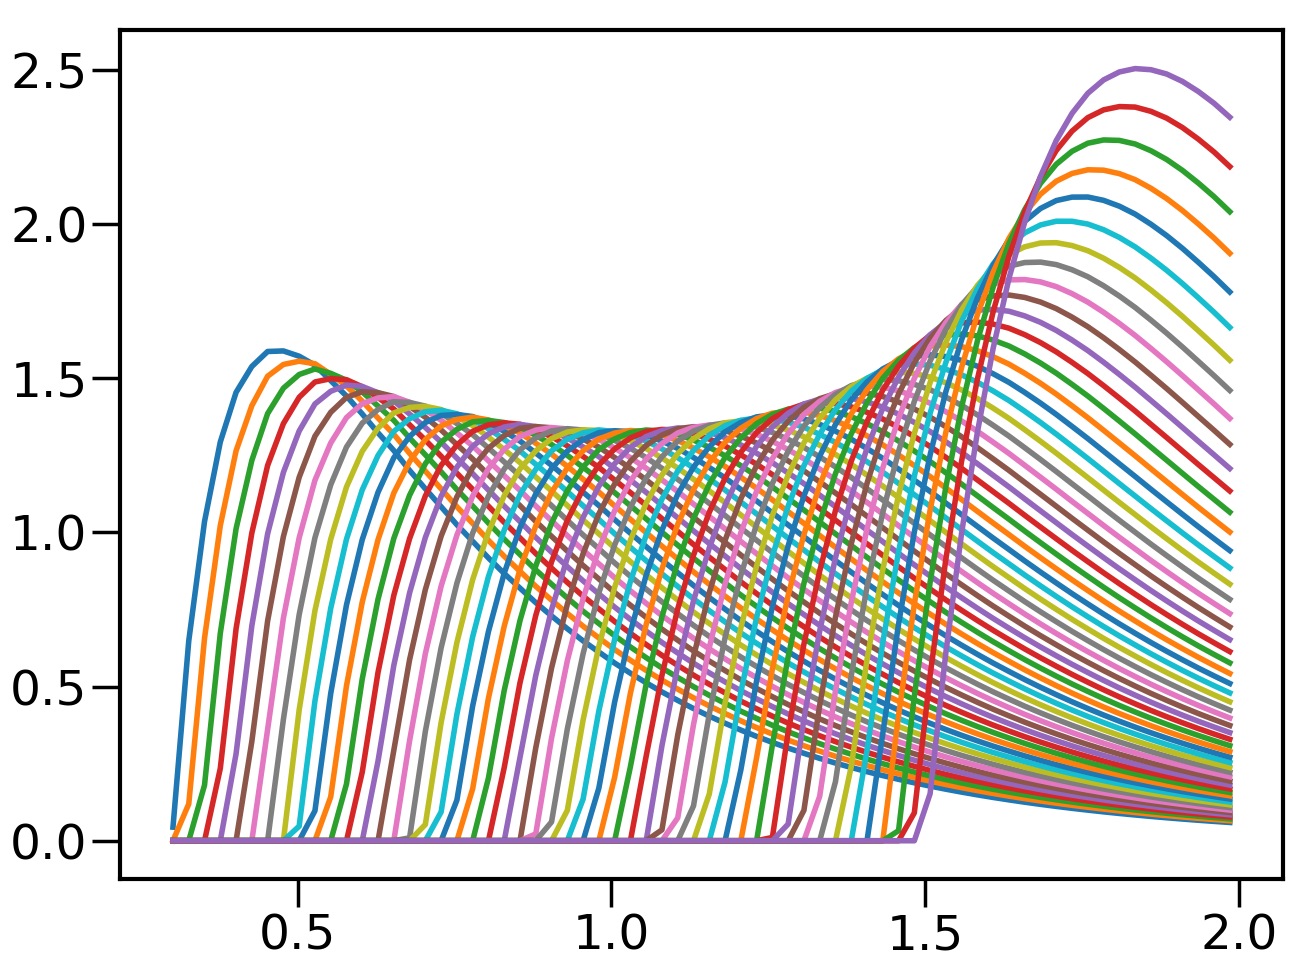

In [25]:
nb=kappaL.zs_bins['n_bins']
for i in np.arange(nb):
    zb=kappaL.zs_bins[i]
    plot(zb['z'],zb['pz'])
#     print(np.sum(zb['nz']))
#     print(zb['z'],zb['pz'])
# yscale('log')
# ylim(2.e-4,20)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


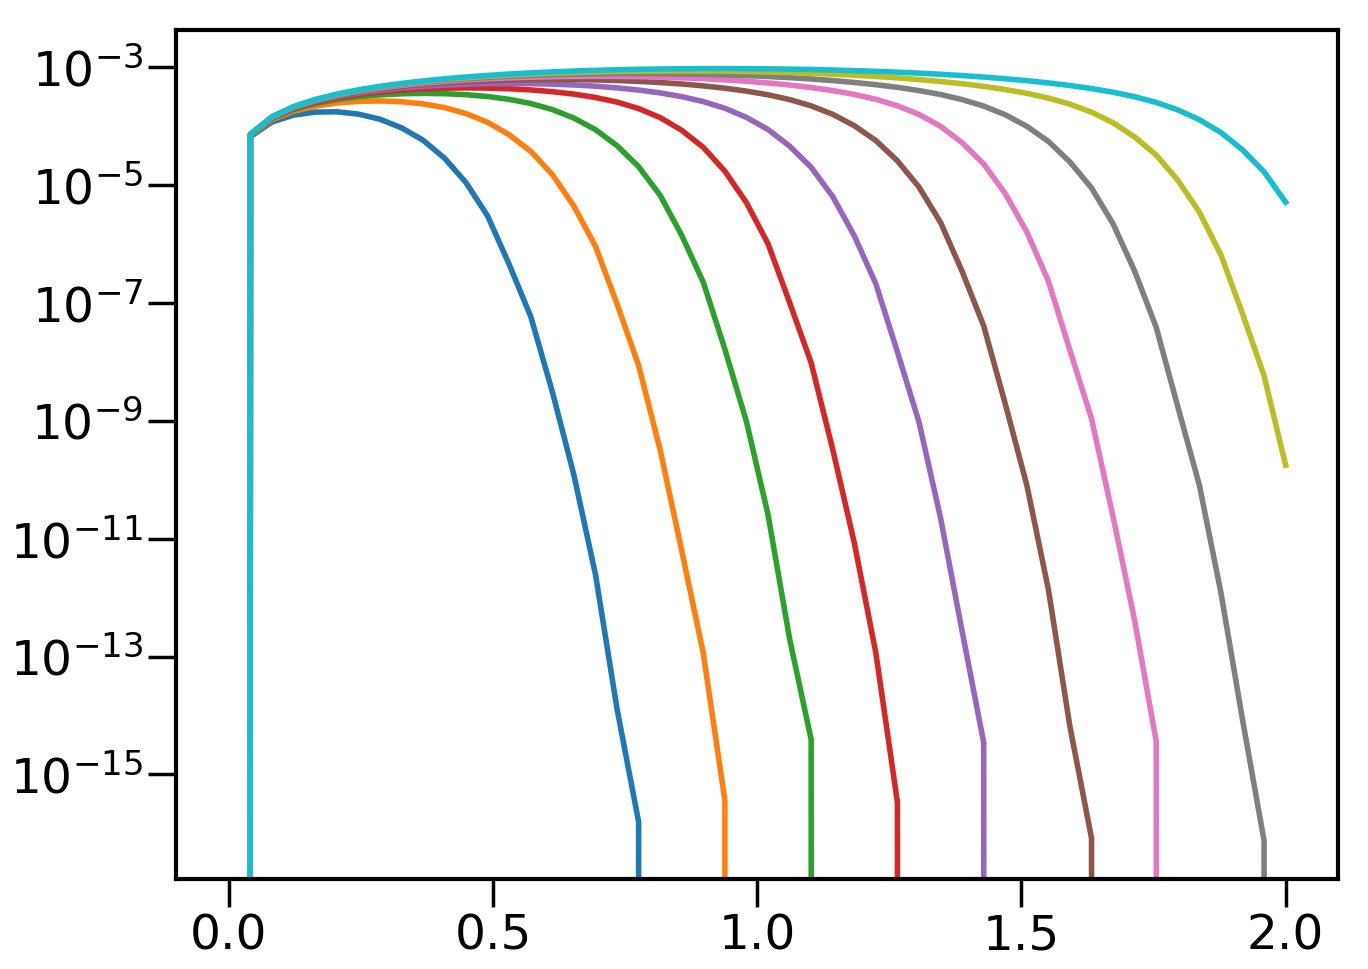

In [26]:
nb=kappaS.zs_bins['n_bins']
zl=kappaS.zs_bins['z_lens_kernel']
for i in np.arange(nb):
    zb=kappaS.zs_bins[i]
    plot(zl,zb['lens_kernel'])
#     print(np.sum(zb['nz']))
#     print(zb['z'],zb['pz'])
yscale('log')
# ylim(2.e-4,20)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


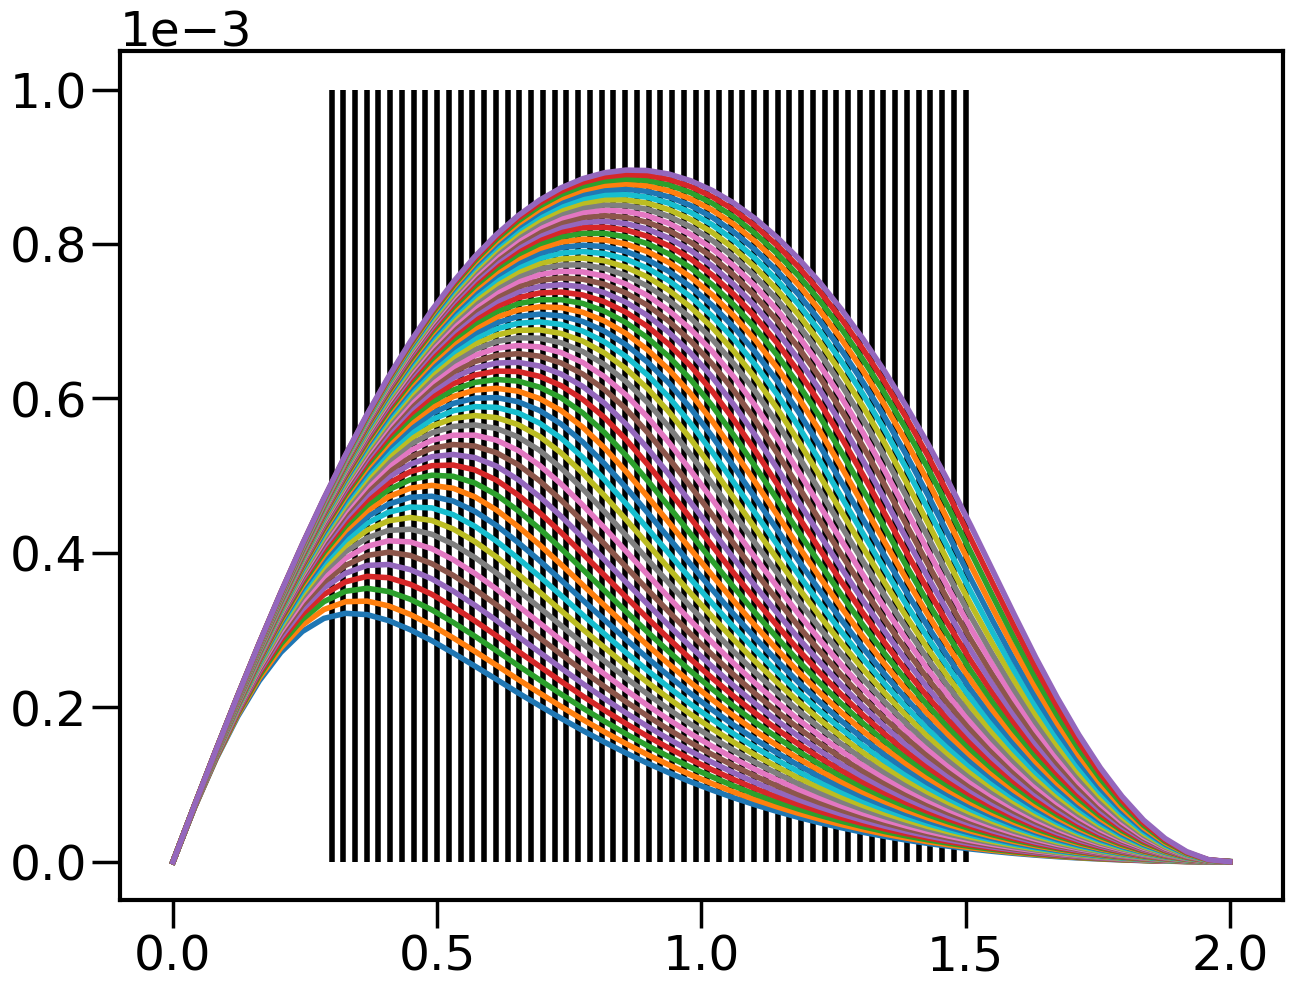

In [27]:
nb=kappaL.zs_bins['n_bins']
zb2=kappaL.zs_bins['z_bins']
zl=kappaL.zs_bins['z_lens_kernel']
for i in np.arange(nb):
    zb=kappaL.zs_bins[i]
    plot(zl,zb['lens_kernel'])
    vlines(zb2[i],0,1.e-3)
#     print(np.sum(zb['nz']))
#     print(zb['z'],zb['pz'])
# yscale('log')
# ylim(2.e-8,2.e-5)

In [28]:
%time clSG=kappaS.kappa_cl_tomo()
%time clLG=kappaL.kappa_cl_tomo()#kappa_cl_tomo()

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


CPU times: user 895 ms, sys: 91 ms, total: 986 ms
Wall time: 778 ms
CPU times: user 2.99 s, sys: 360 ms, total: 3.35 s
Wall time: 2.71 s


In [29]:
%time clS=clSG['stack'].compute()
%time clL=clLG['stack'].compute()
covS_inv=np.linalg.inv(clS['cov'])
print (np.sqrt(np.dot(clS['cl'],np.dot(covS_inv,clS['cl']))))
covL_inv=np.linalg.inv(clL['cov'])
print (np.sqrt(np.dot(clL['cl'],np.dot(covL_inv,clL['cl']))))

CPU times: user 2min 10s, sys: 8.15 s, total: 2min 19s
Wall time: 1min 17s
CPU times: user 2min 11s, sys: 8.86 s, total: 2min 19s
Wall time: 1min 19s
246.231168768
242.693969953


KeyboardInterrupt: 

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


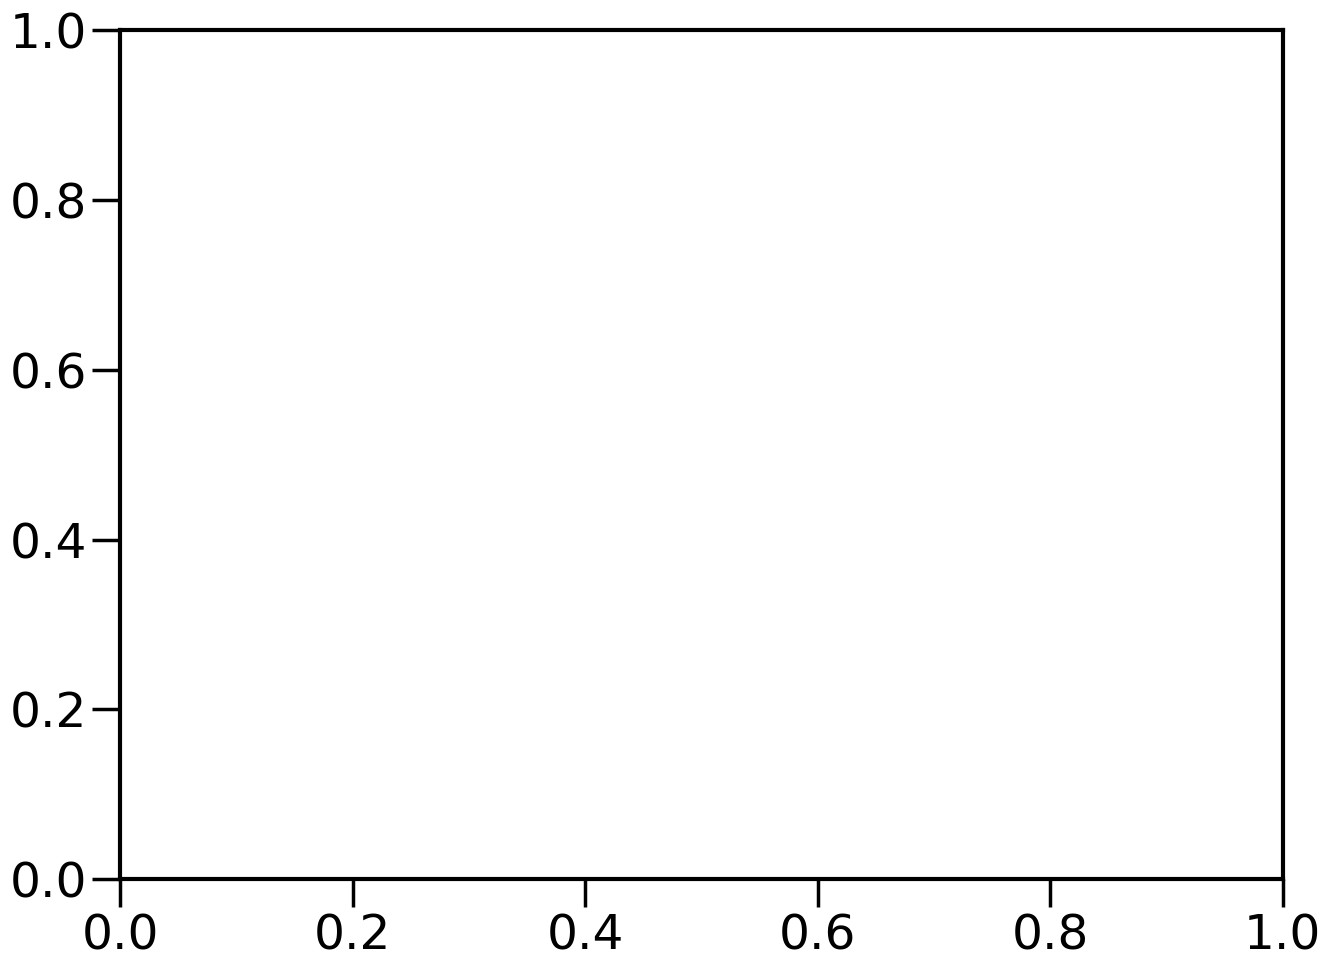

In [427]:
cc=kappaS.cov_utils
corrS=cc.corr_matrix(clS['cov'])
corrL=cc.corr_matrix(clL['cov'])
pcolor(corrS,vmin=-1,vmax=1,cmap='seismic')
show()
pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [358]:
# %time clS['cl']=clSG['cl0'].compute()
clL['cli']=clLG['cl0'].compute()
clS['cli']=clSG['cl0'].compute()
# clS['cov']=clSG['cov0'].compute()
# clL['cov']=clLG['cov0'].compute()



/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


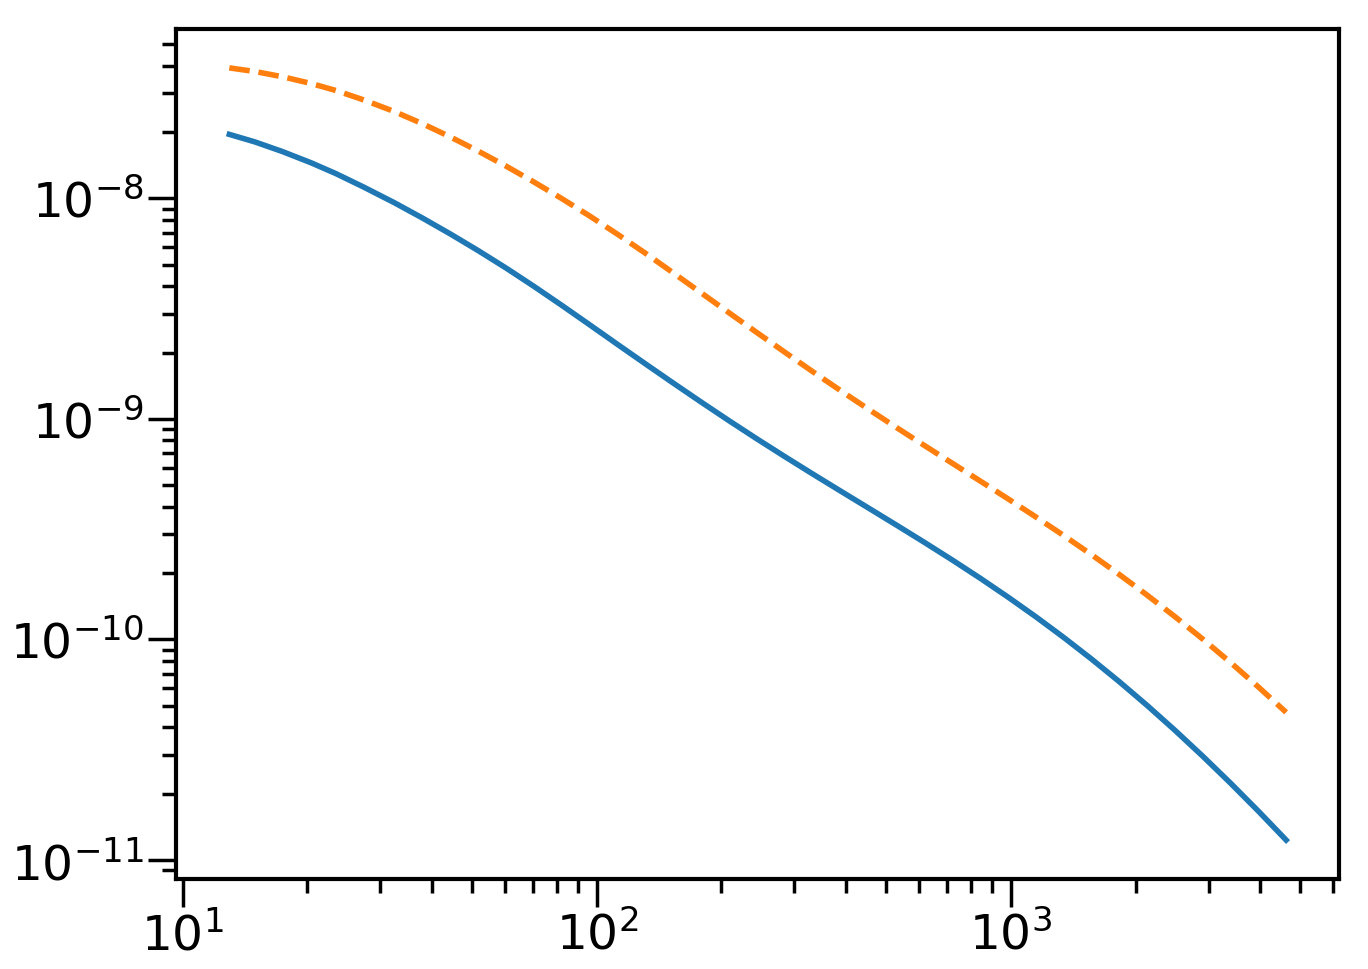

In [113]:
plot(lb,clS['cli'][:,0,0])
plot(lb,clL['cli'][:,0,0],'--')
xscale('log')
yscale('log')

ValueError: x and y must have same first dimension, but have shapes (39,) and (234,)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


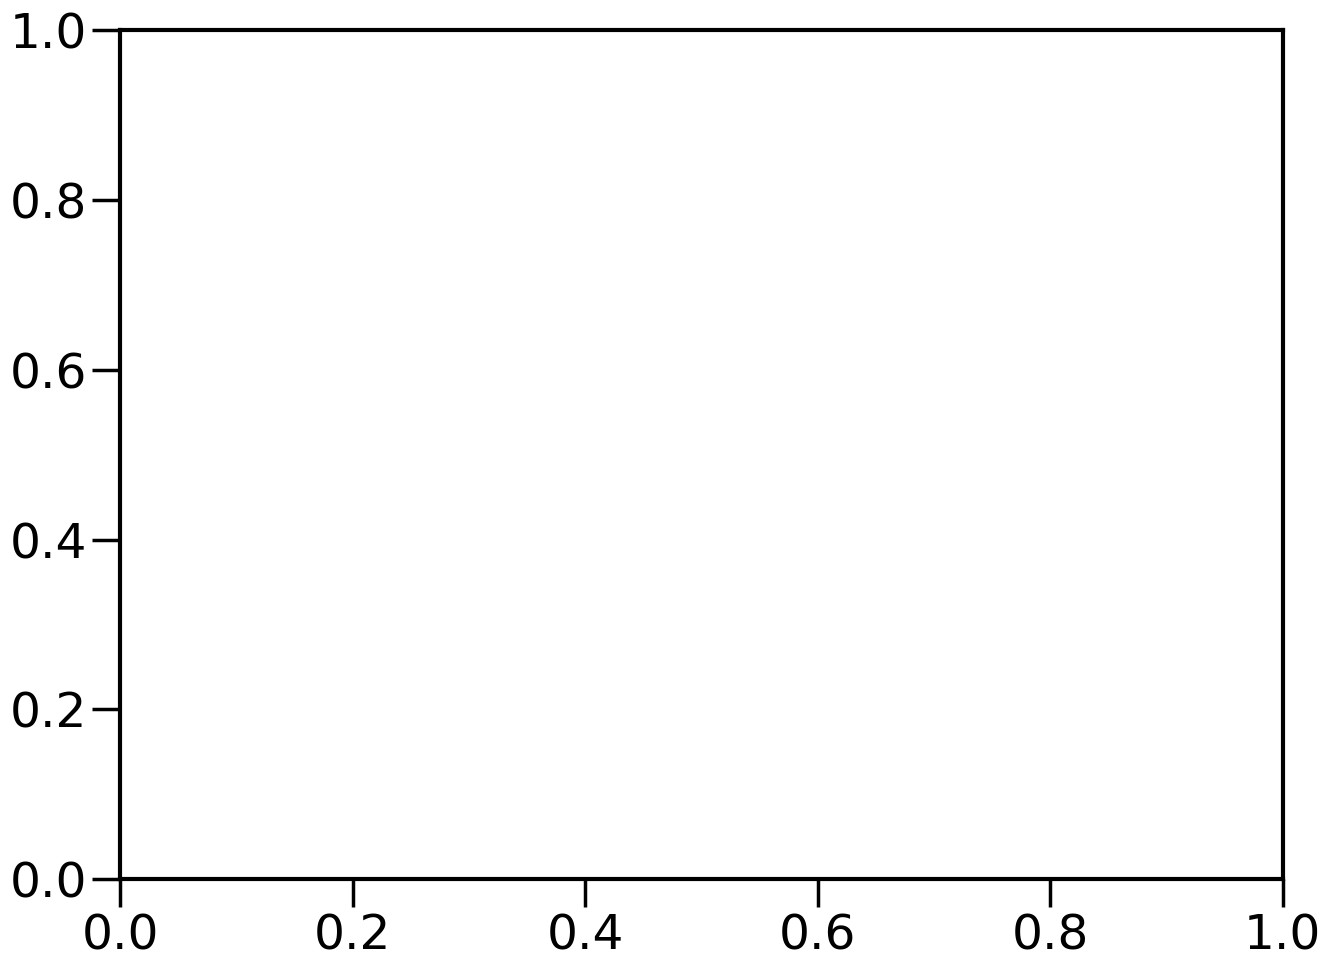

In [127]:
plot(lb,clS['cl'])
plot(lb,clL['cl'],'--')
xscale('log')
yscale('log')

In [ ]:
plot(l_bins[:-1],np.sqrt(np.diag(clS['cov'])))
plot(l_bins[:-1],np.sqrt(np.diag(clL['cov'])),'--')
xscale('log')
yscale('log')

In [ ]:
plot(l_bins[:-1],clS['cl']/np.sqrt(np.diag(clS['cov'])))
plot(l_bins[:-1],clL['cl']/np.sqrt(np.diag(clL['cov'])),'--')
xscale('log')
yscale('log')

In [ ]:
plot(l_bins[:-1],np.sqrt(np.diag(clS['cov']))/np.sqrt(np.diag(clL['cov'])))
plot(l_bins[:-1],clS['cl']/clL['cl'],'--')
xscale('log')
# yscale('log')

In [ ]:
plot(z,kappaL.zs_bins[0]['W'])

In [ ]:
xiSG['stack'].visualize()

In [ ]:
%time clSG=kappaS.kappa_cl_tomo()
clLG=kappaL.kappa_cl_tomo()#kappa_cl_tomo()
# %time clS=clSG['stack'].compute()
# %time clL=clLG['stack'].compute()

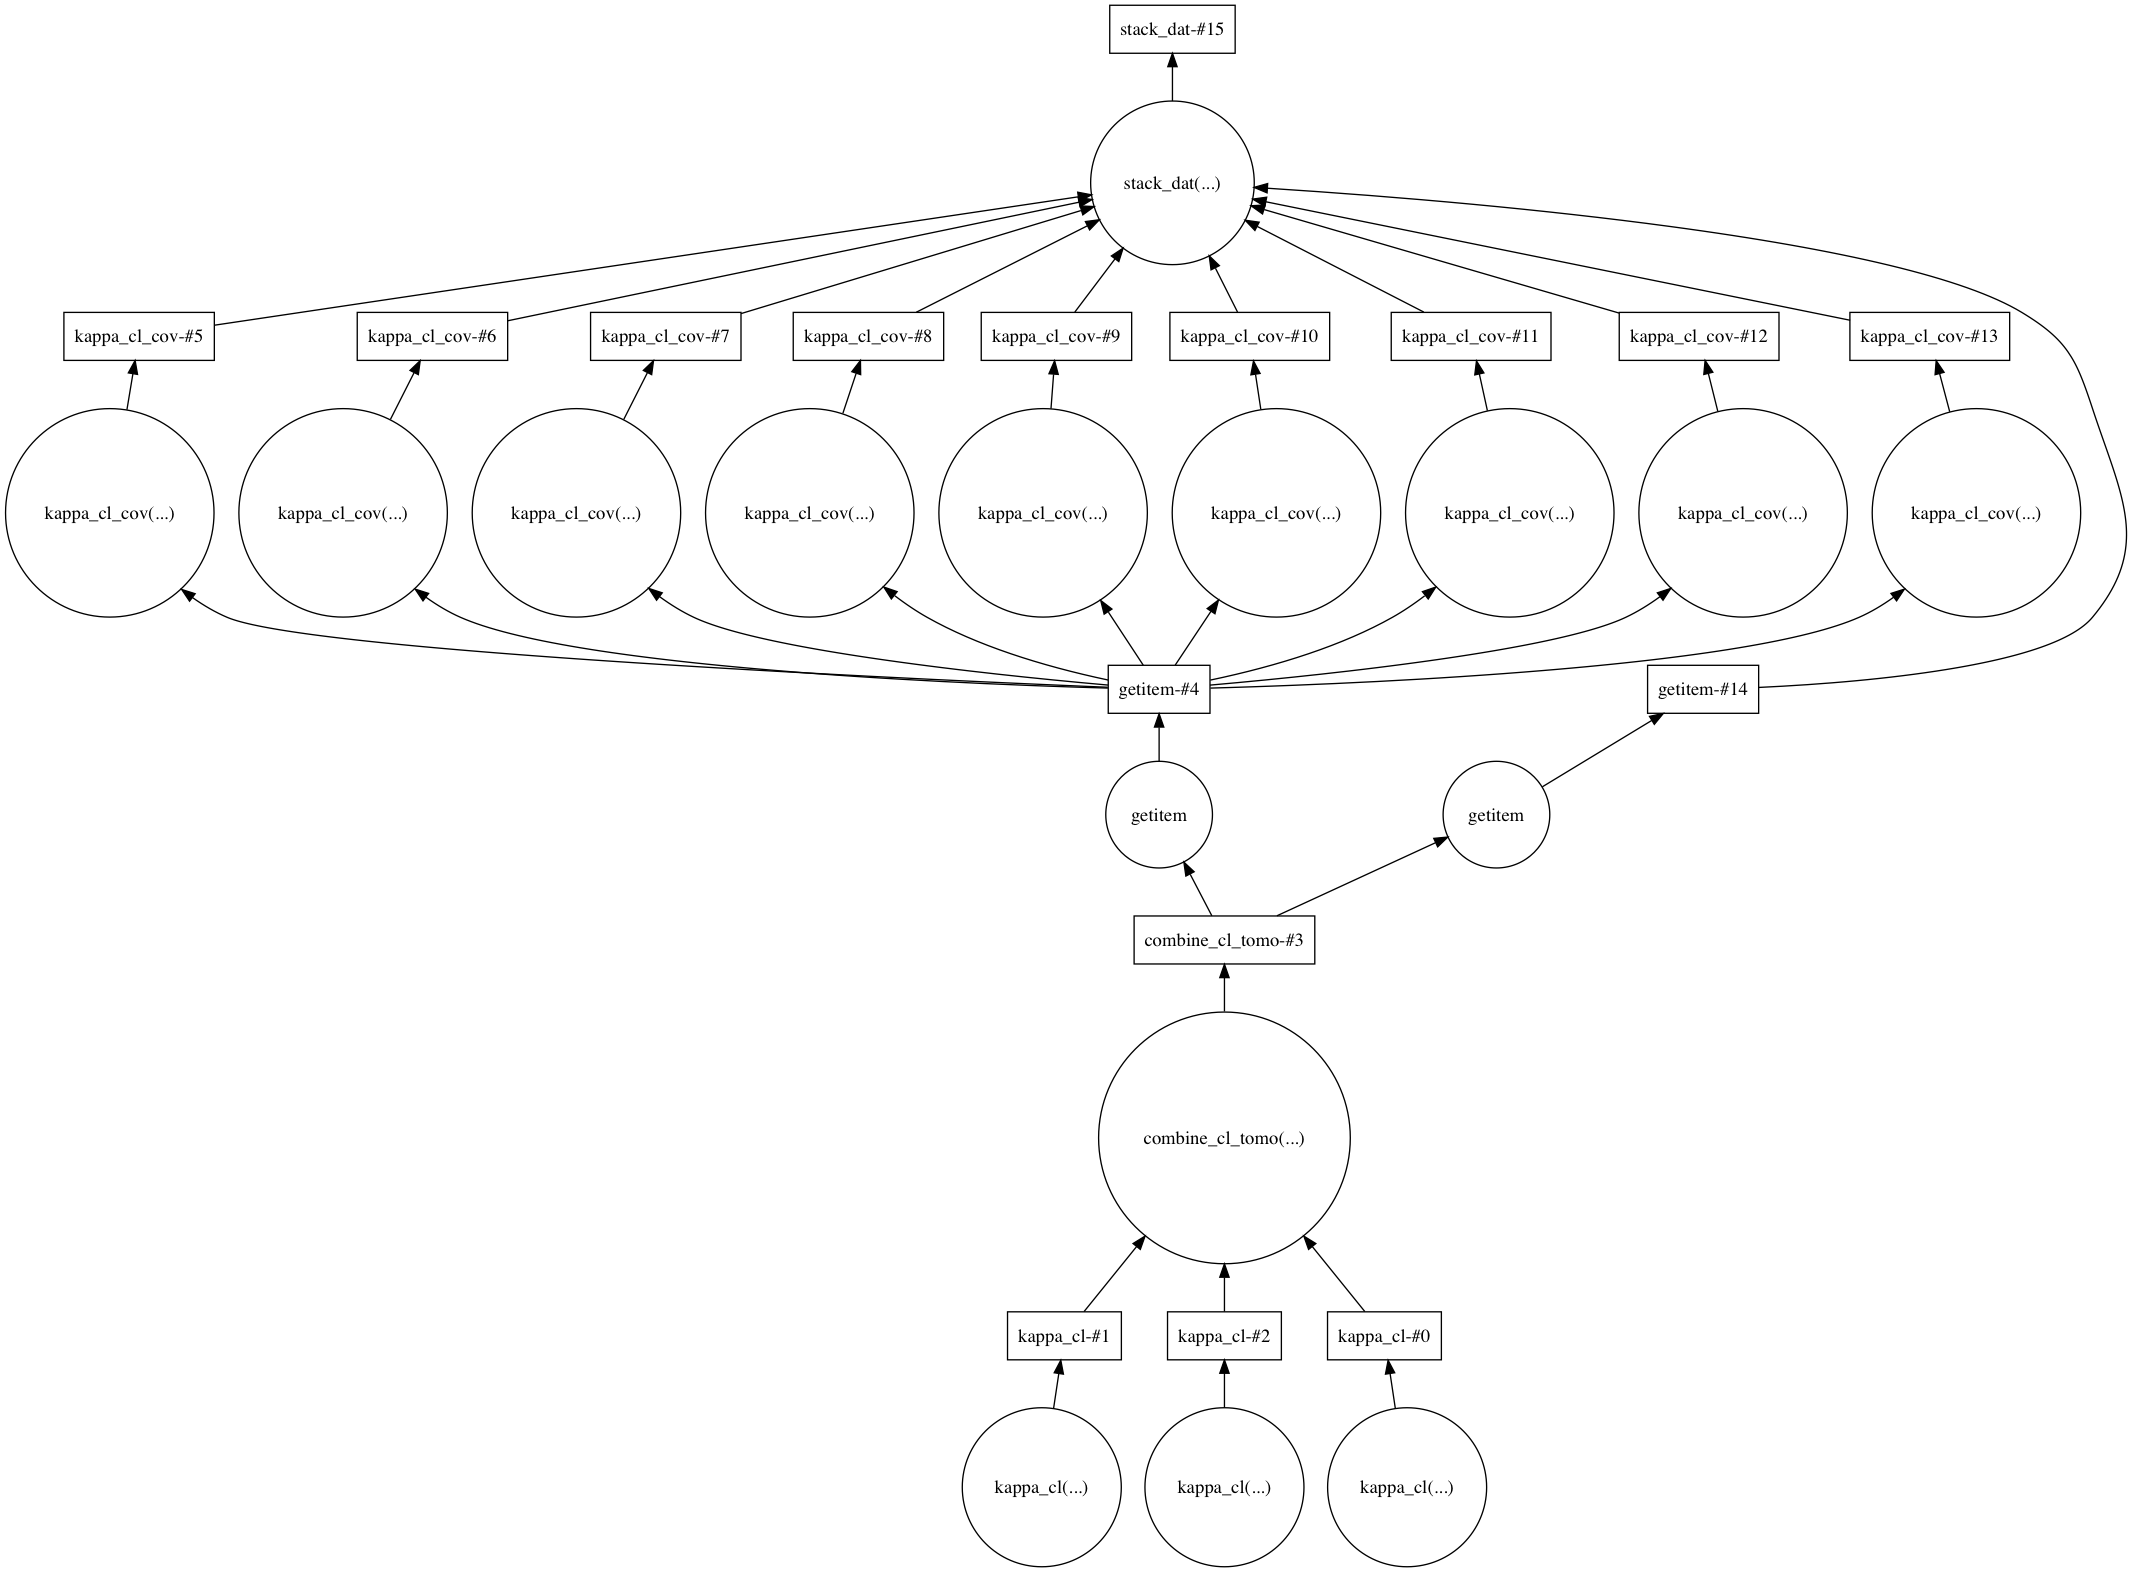

In [90]:
clSG['stack'].visualize()

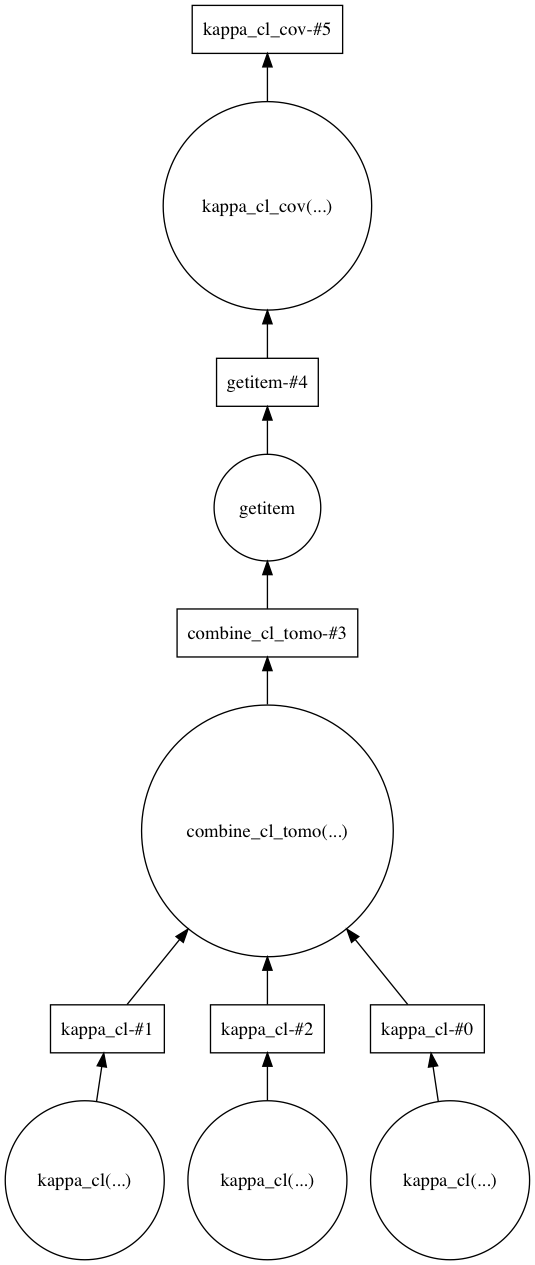

In [31]:
clSG['cov0'][(0,0,0,0)].visualize()

In [32]:
kappaS.SN

array([[[ 0.,  0.],
        [ 0.,  0.]]])

In [33]:
kappaL.SN

array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]])

In [128]:
cl_b_stack=clS#kappaS.stack_dat(clS)
cl_Lb_stack=clL#kappaL.stack_dat(clL)
#clstack=kappaS.stack_dat(clS)

In [129]:
covS_inv=np.linalg.inv(cl_b_stack['cov'])
print (np.sqrt(np.dot(cl_b_stack['cl'],np.dot(covS_inv,cl_b_stack['cl']))))
covL_inv=np.linalg.inv(cl_Lb_stack['cov'])
print (np.sqrt(np.dot(cl_Lb_stack['cl'],np.dot(covL_inv,cl_Lb_stack['cl']))))

286.807331994
353.652807689


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


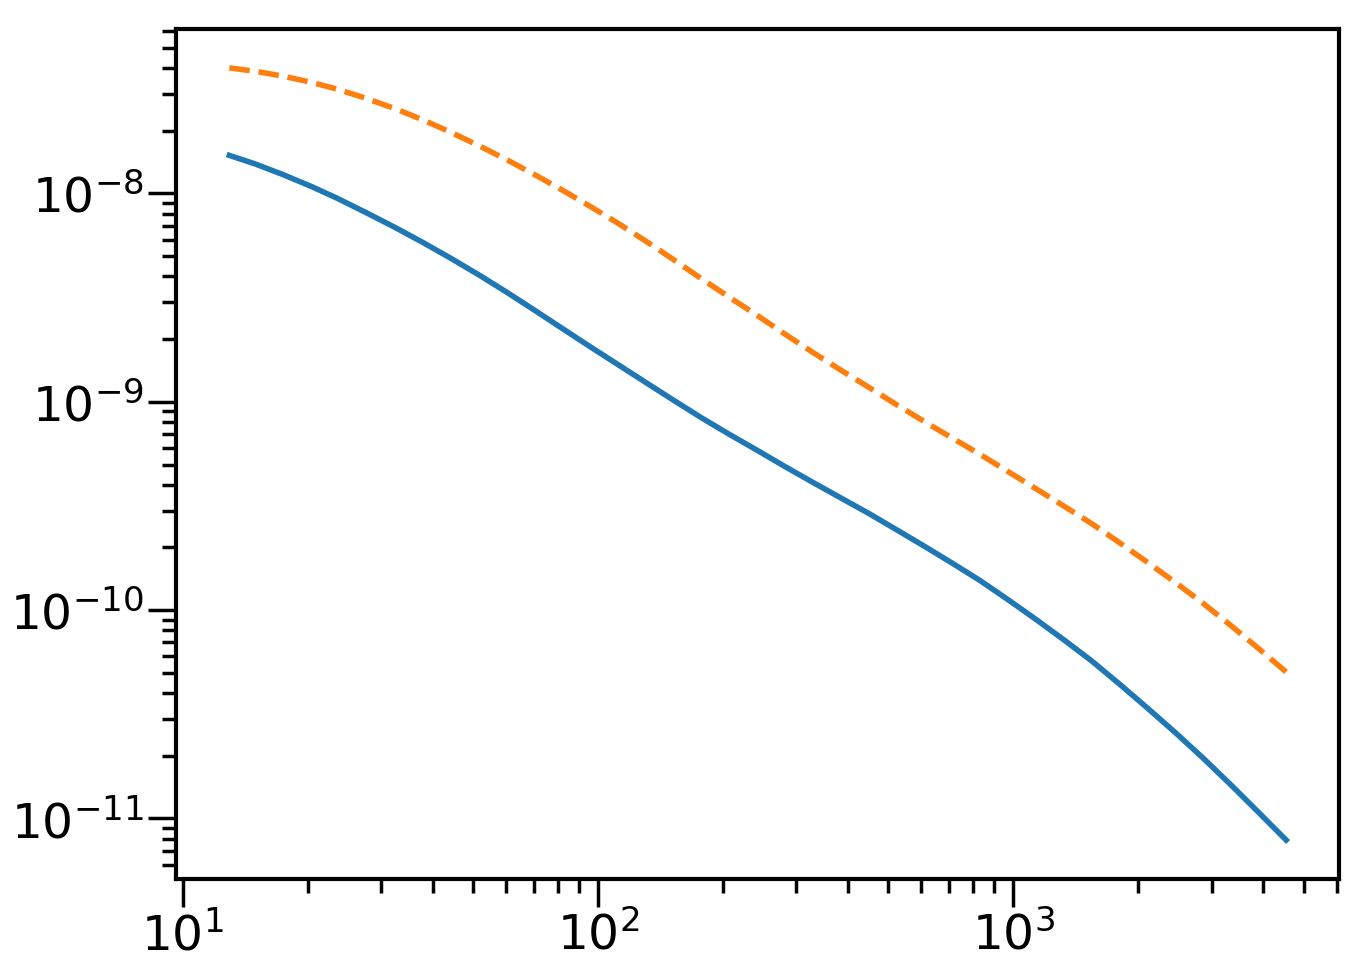

In [36]:
plot(clS['l'],clS['cl'][:,0,0])
#plot(clSb['l'],clSb['cl'][:,0,0])

plot(clL['l'],clL['cl'][:,0,0],ls='--')
# plot(clLb['l'],clLb['cl'][:,0,0])
xscale('log')
yscale('log')

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


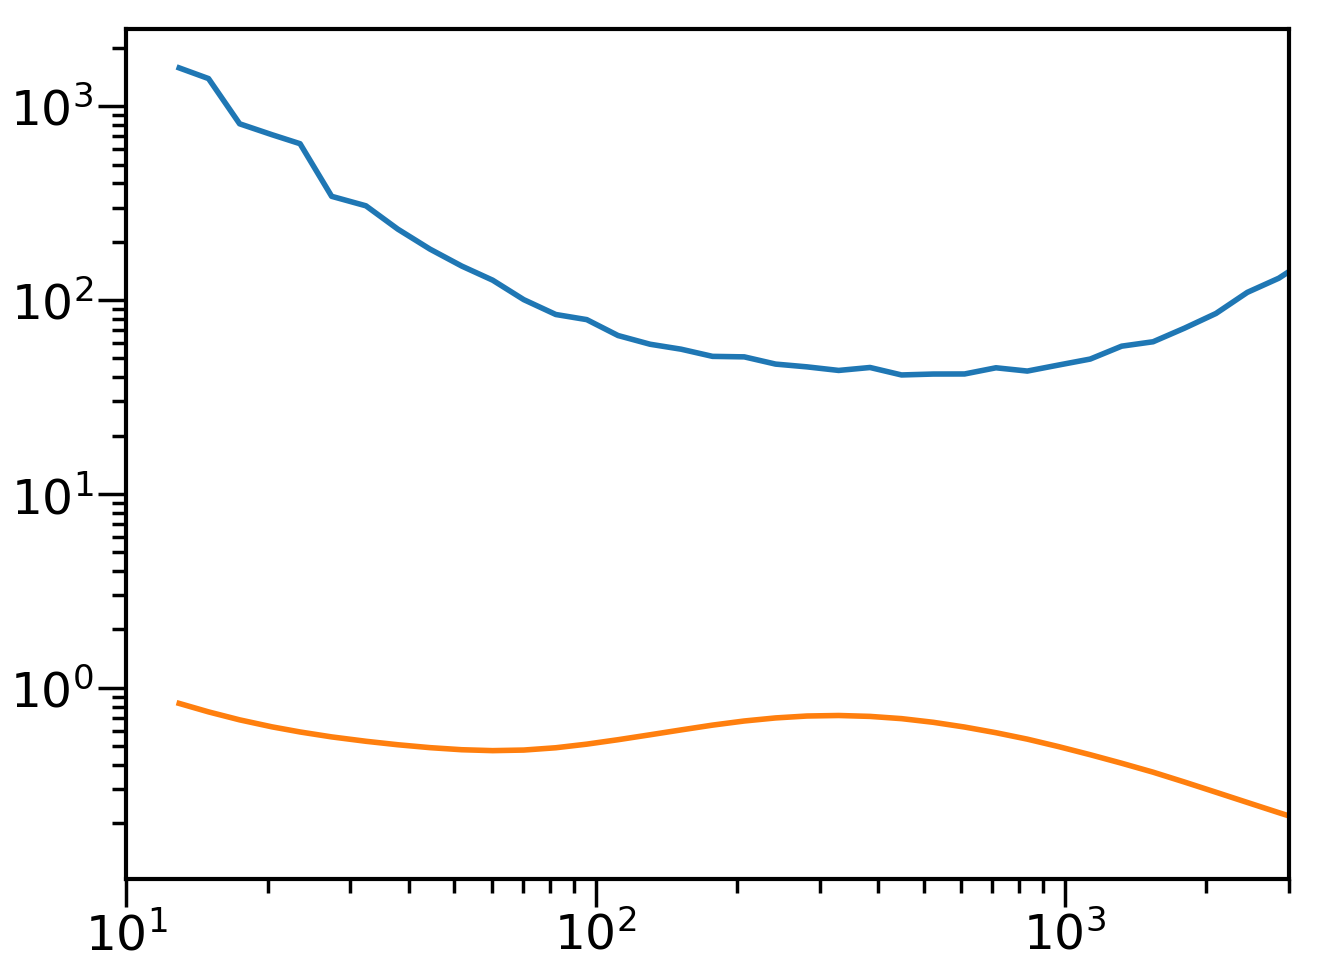

In [24]:
#cov0=clS['cov'][(0,0,0,0)]
f=1.e4
cl00=clSb
cl01=clS
cov0=cl00['cov'][(0,0,0,0)]
cov01=cl01['cov'][(0,0,0,0)]
cl_t=cl00['cl'][:,0,0]
cl_t1=cl01['cl'][:,0,0]
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
# plot(l,np.diag(cov01['G'])/cl_t1**2*f)
# plot(l,np.diag(cov01['SSC_dd'])/cl_t1**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


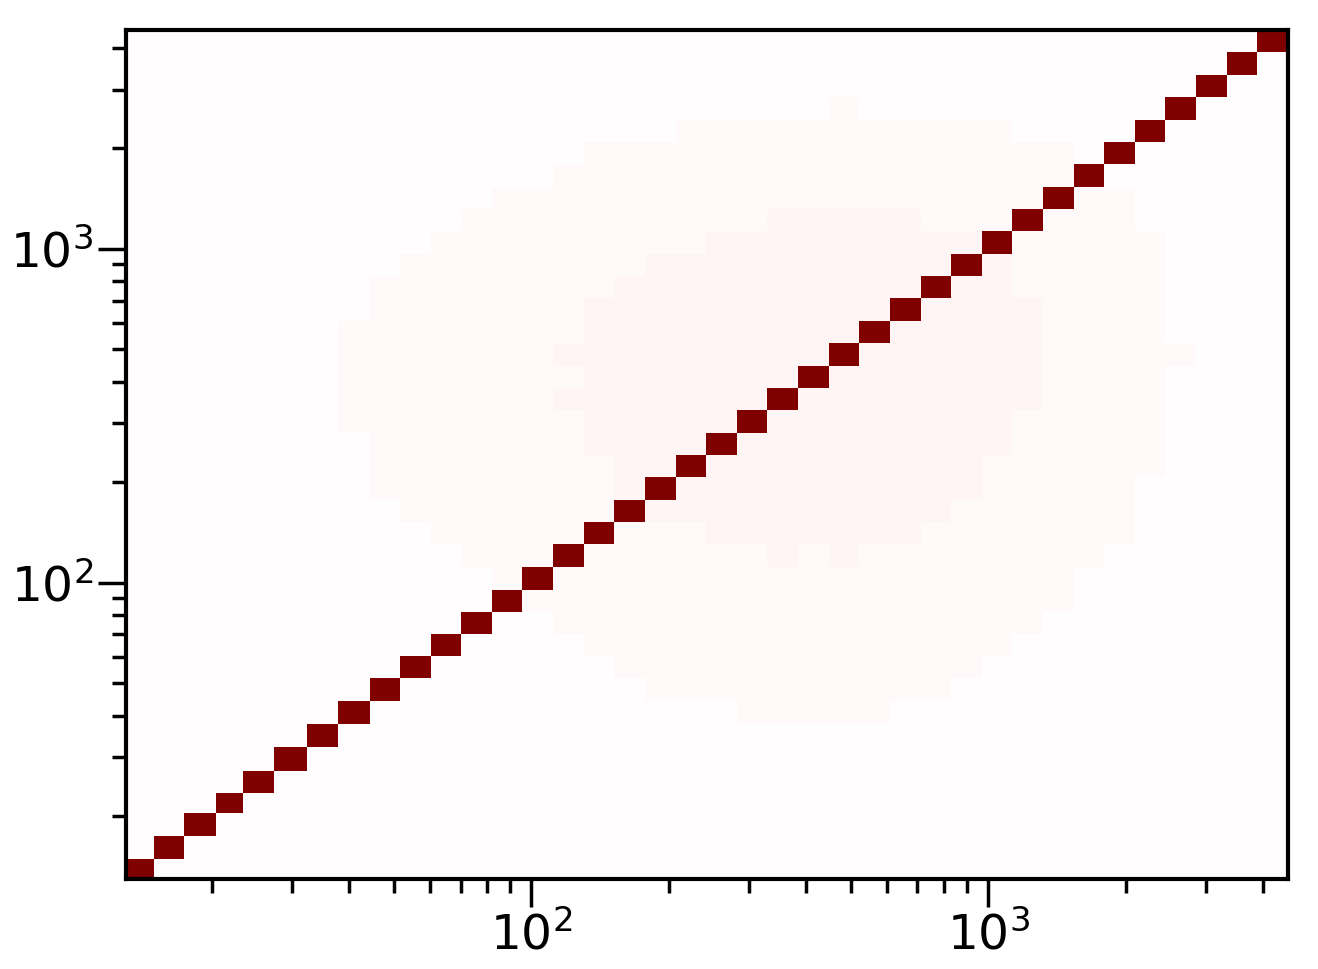

In [25]:
corr2=cc.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


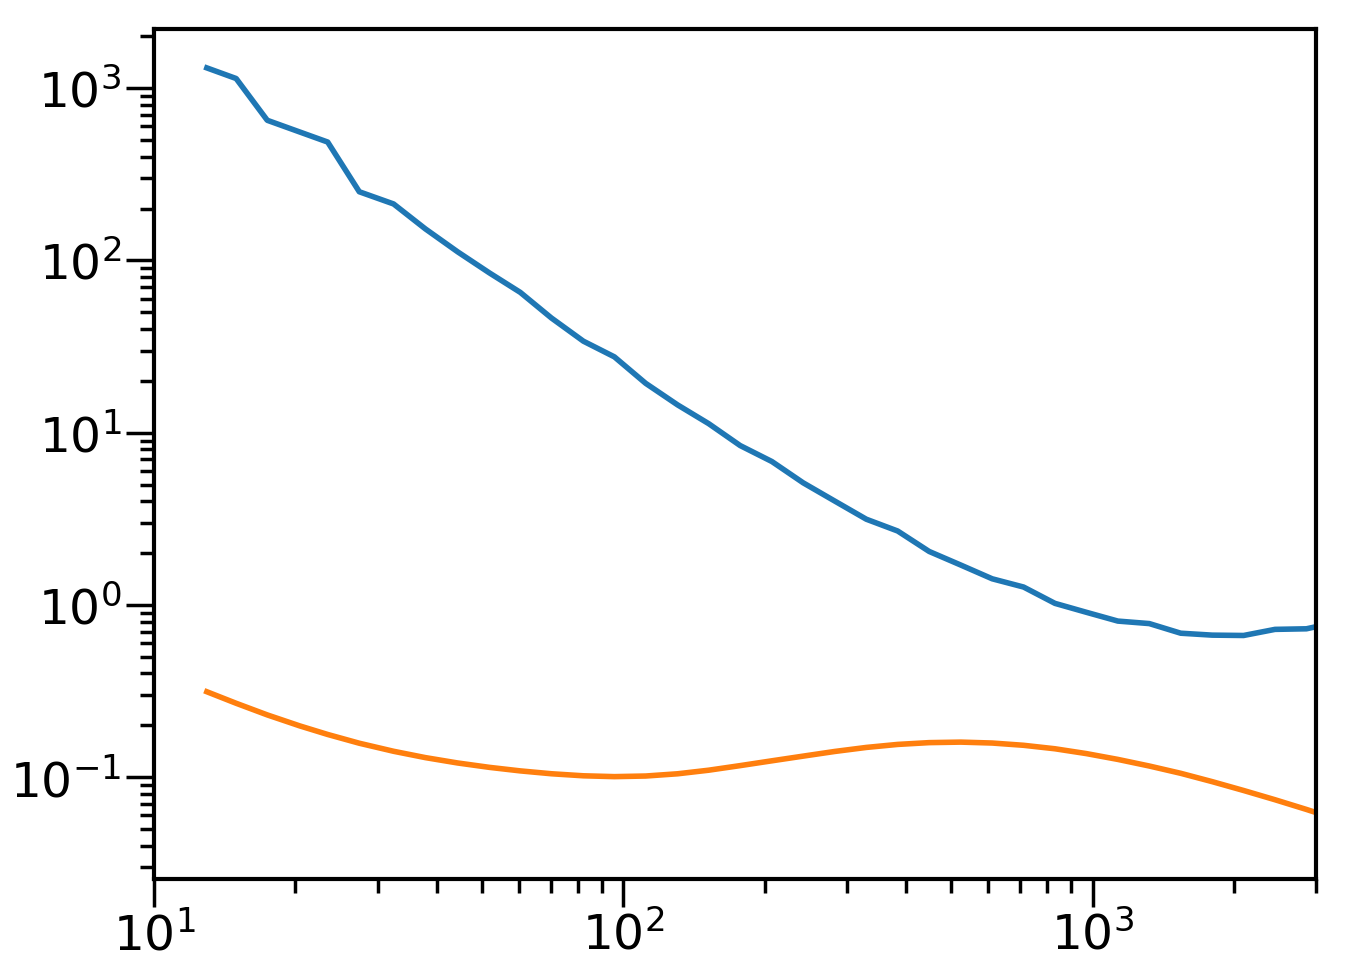

In [26]:
#cov0=clS['cov'][(0,0,0,0)]
f=1.e4
cl00=clLb
cl01=clL
cov0=cl00['cov'][(0,0,0,0)]
cov01=cl01['cov'][(0,0,0,0)]
cl_t=cl00['cl'][:,0,0]
cl_t1=cl01['cl'][:,0,0]
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
# plot(l,np.diag(cov01['G'])/cl_t1**2*f)
# plot(l,np.diag(cov01['SSC_dd'])/cl_t1**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

In [66]:
x=np.linspace(1,2,10+1)

for i in np.arange(10):
    x[i:i+2]

In [227]:
from astropy.cosmology import Planck15 as cosmo
cosmo_h=cosmo.clone(H0=100)

In [251]:
sc=lu.sigma_crit(zl=zl,zs=zs,cosmo_h=cosmo_h)
np.sum(sc,axis=1)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


array([ inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf])

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


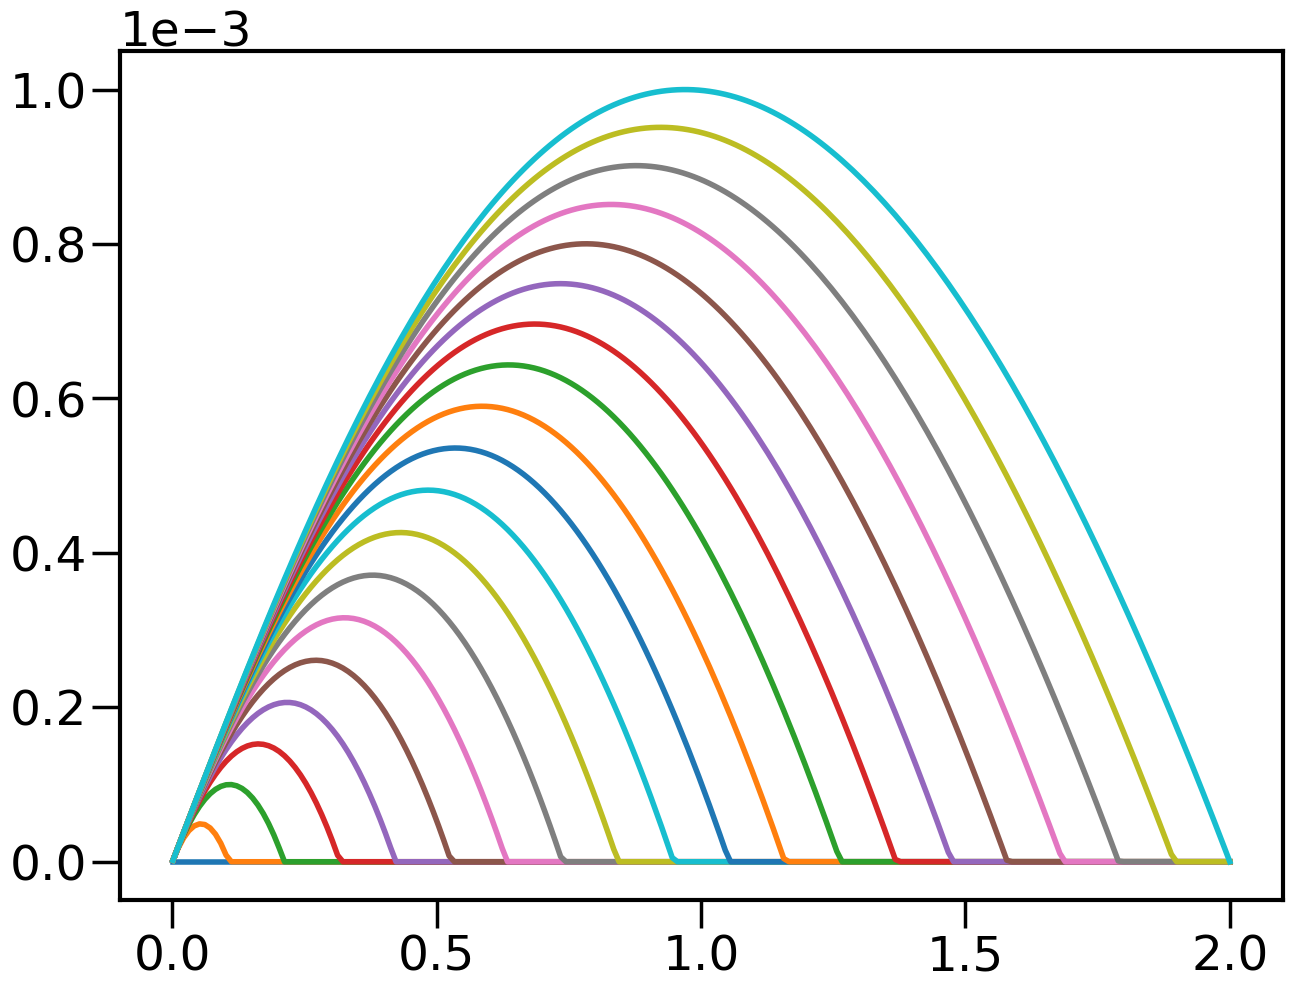

In [229]:
lu=Lensing_utils()
zl=np.linspace(0.001,2,200)
zs=np.linspace(0.001,2,20)

for z in zs:
    sc=lu.sigma_crit(zl=zl,zs=z,cosmo_h=cosmo_h)
    plot(zl,1./sc)